In [1]:
from baseline_cnn import *
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as func
import torch.nn.init as torch_init
import torch.optim as optim

# Data utils and dataloader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Custom utils file
from utils import evaluate

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA NOT supported


## Load Train, Validation and Test data

In [4]:
transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor()])
dataset = loader('mini_train.csv','./datasets/cs154-fa19-public/',transform=transform)
testdataset = loader("mini_test.csv", './datasets/cs154-fa19-public/', transform=transform)

batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
# indices = list(range((int)(dataset_size/4))) # smmall part for experiments 
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=len(testdataset),
                                        shuffle=False)

## Show a sample from the dataset

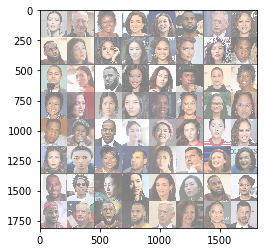

tensor([ 1,  6,  8,  7,  7,  5,  6,  9,  5,  7,  9,  1,  9,  9,  1, 10,  2,  1,
         5,  1,  1, 10,  2,  8,  8,  7,  1,  1, 10,  9,  9,  9, 10,  8, 10,  1,
         1,  1,  1,  9,  1,  1,  8,  4,  1,  4,  7,  7,  5, 10,  1,  1,  7,  1,
         5,  9,  5,  6,  5,  5,  6,  7,  9,  3])


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next() # We get batch_size number of images by calling .next()

# Places the images in a grid
imshow(torchvision.utils.make_grid(images))
print(labels)

## Create the network

In [8]:
NUM_CLASSES = 11
net=Nnet(num_classes=NUM_CLASSES).to(computing_device)
net.apply(weights_init)
print(net)

Nnet(
  (main): Sequential(
    (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(21, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(20, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(15, 7, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=1183, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=300, out_features=11, bias=True)
  )
)


## Define the Lossfunction and the Optimizer

In [9]:
#criterion = nn.CrossEntropyLoss(weight=dataset.get_class_weights()) # Weighted Loss
criterion = nn.CrossEntropyLoss()

# Pass the weights of the network (net.parameters) to the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005) 

## Train the network

In [11]:
# Track the loss across training
train_epoch_losses = []
validation_epoch_losses = []
train_batch_losses = []
validation_batch_losses = []
avg_minibatch_loss = []
N = 50 # Intervall of average minibatch loss reporting.
n_epochs = 2
PATH = "./cnn_celeb.pth"  # Where to save the model

for epoch in range(n_epochs):
    N_minibatch_loss = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        fraction_done = round(minibatch_count/len(dataset)*100, 3)
        print("{} percent of epoch {} complete".format(fraction_done, epoch + 1), end="\r")
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(images)
        
        loss = criterion(outputs, labels) # If we are using Cross Entropy, this is doing Softmax
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()
        # Add this iteration's loss to the total_loss
        train_batch_losses.append(loss.item())
        N_minibatch_loss += loss

        if minibatch_count % N == 49:
            # Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            print('Epoch %d, average minibatch %d loss: %.3f' % (epoch + 1, minibatch_count + 1, N_minibatch_loss))
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            N_minibatch_loss = 0.0

    print("Finished", epoch + 1, "epochs of training")
    print("Saving model...")
    torch.save(net.state_dict(), PATH)
    print("Done.")

    # save train loss
    train_epoch_loss = np.average(np.array(train_batch_losses))
    train_batch_losses = []
    train_epoch_losses.append(train_epoch_loss)

    with torch.no_grad():
        # validation implementation
        for minibatch_count, (images, labels) in enumerate(validation_loader, 0):
            # Put the validation minibatch data in CUDA Tensors and run on the GPU if supported
            images, labels = images.to(computing_device), labels.to(computing_device)
            # Perform the forward pass through the network and compute the loss
            outputs = net(images)

            validation_batch_loss = criterion(outputs, labels)
            validation_batch_losses.append(validation_batch_loss)

        epoch_validation_loss = np.average(np.array(validation_batch_losses))
        validation_batch_losses = []
        validation_epoch_losses.append(epoch_validation_loss)

    print('Epoch %d, validation loss: %.3f' % (epoch + 1, epoch_validation_loss))

Finished 1 epochs of traininglete
Saving model...
Done.
Epoch 1, validation loss: 2.017
Finished 2 epochs of traininglete
Saving model...
Done.
Epoch 2, validation loss: 1.815


## Test the model

In [12]:
with torch.no_grad():
    for images, labels in test_loader: # Remember they come in batches
        # Since we are not doing this through criterion, we must add softmax our self
        outputs = func.softmax(net(images), dim=1) 
        _, predicted = torch.max(outputs.data, 1)
        
        predicted = func.one_hot(predicted, num_classes=NUM_CLASSES).type(torch.FloatTensor)
        labels = func.one_hot(labels, num_classes=NUM_CLASSES).type(torch.FloatTensor)
        evaluate(predicted, labels)


-----------------------------------------------------------------
Class     Accuracy  Precision Recall    BCR       AggregatedScore
-----------------------------------------------------------------
0         1.000     0.000     0.000     0.000     0.250     
1         0.725     0.397     0.844     0.620     0.646     
2         0.946     0.000     0.000     0.000     0.237     
3         0.916     0.000     0.000     0.000     0.229     
4         0.904     0.000     0.000     0.000     0.226     
5         0.964     0.818     0.692     0.755     0.807     
6         0.940     1.000     0.091     0.545     0.644     
7         0.862     0.556     0.400     0.478     0.574     
8         0.940     0.000     0.000     0.000     0.235     
9         0.641     0.254     0.630     0.442     0.491     
10        0.940     1.000     0.091     0.545     0.644     


## Plot loss

[2.0760913372039793, 1.8646096587181091]
[2.0171342, 1.8148569]


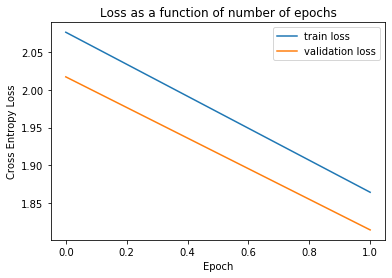

In [13]:
print(train_epoch_losses)
print(validation_epoch_losses)

plt.plot(train_epoch_losses, label="train loss")
plt.plot(validation_epoch_losses, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss as a function of number of epochs")
plt.legend()
plt.show()


## Plot Weights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

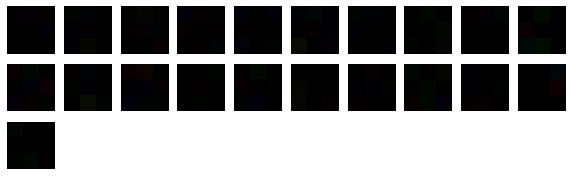

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

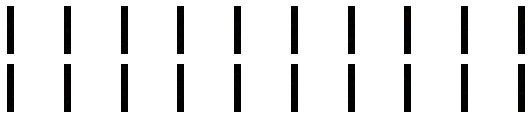

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

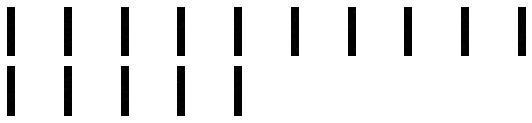

In [14]:
COLUMNS_IN_FIGURE = 10

def plot_weights(model, layer):
    weight_tensor = model.main._modules.get(str(layer)).weight.data
    if not weight_tensor.shape[-1] == 3:
        raise Exception("last dim needs to be 3")
    num_weights = weight_tensor.shape[0]
    num_rows = 1 + num_weights // COLUMNS_IN_FIGURE
    fig = plt.figure(figsize=(COLUMNS_IN_FIGURE, num_rows))
    for i in range(weight_tensor.shape[0]):
        sub = fig.add_subplot(num_rows, COLUMNS_IN_FIGURE, i + 1)
        sub.axis('off')
        sub.imshow(weight_tensor[i])
        sub.set_xticklabels([])
        sub.set_yticklabels([])

    plt.show()

    
    

plot_weights(net, 0)
plot_weights(net, 2)
plot_weights(net, 5)